XGBoost

In [26]:
import xgboost as xgb
import numpy as np
import matplotlib.pylab as plt
plt.style.use('ggplot')
import feature_engineering
#from feature_engineering import add_retning
from sklearn.model_selection import train_test_split
import sys
sys.path.append('../data')

from display_data import import_data
import pandas as pd


HEr kommer funksjonene

In [27]:
def add_radius(df):
    #adds radius column to dataframe
    df['radius'] = np.sqrt((df['latitude']-55.75)**2 + (df['longitude']-37.55)**2)
    return df

def group_by_feature_and_price(df, feature, data_train = pd.DataFrame()):
    #makes a new column with the mean price for each group to all rows
    if data_train.empty:
        grouped = df.groupby([feature])

        mean_price = grouped['price'].mean()

        df_merged = pd.merge(df,mean_price, on=feature, how='left')

        column_name = str(feature + '_price')

        df[column_name] = df_merged['price_y']
    else:
        grouped = data_train.groupby([feature])

        mean_price = grouped['price'].mean()

        df_merged = pd.merge(df,mean_price, on=feature, how='left')

        column_name = str(feature + '_price')

        df[column_name] = df_merged['price']
    return df

def one_hot_encode(df, column_to_encode):
    """one hots encode for one singel column"""
    encoded_df = pd.get_dummies(df[[column_to_encode]].astype(str))
    df = pd.concat([df,encoded_df],axis=1)
    return df

def one_hot_encode_multiple(df, list_of_columns):
    """takes in multiple columns and runs one hot encode for each column"""
    for column_to_encode in list_of_columns:
        #print(column_to_encode)
        df = one_hot_encode(df, column_to_encode)
    return df

def add_direction(df):
    """adds direction to dataframe, can be one of eight categories (N,S,W,E)"""
    #straight up (north)
    normal_vector = np.array([0,1])
    #normal_vector = np.tile(normal_vector,(df.shape[0],1))
    #normal_vector = normal_vector.reshape((2,-df.shape[0]))
    temp = pd.DataFrame()
    temp['latitude'] = df['latitude']-55.75
    temp['longitude'] = df['longitude']-37.56


    apartment_vector = temp[['latitude','longitude']].to_numpy()


    #print(np.shape(apartment_vector), np.shape(normal_vector))
    angles = []
    for vector in apartment_vector:
        if vector[0] < 0:
            temp_angle = -angle_between(vector,normal_vector)
        else:
            temp_angle = angle_between(vector,normal_vector)
        angles.append(temp_angle)

    angles = [element * 10 for element in angles]


    angles_series = pd.Series(np.array(angles))
    #angles_series.plot.hist()

    df['direction'] = angles_series
    max = df.direction.max().round()
    min = df.direction.min().round()
    bins = [min,min*7/8,min*5/8,min*3/8,min/8,max/8,max*3/8,max*5/8,max*7/8,max]
    rounded_bins = [element.round() for element in bins]
    #print(rounded_bins)
    direction = pd.cut(df.direction, bins= rounded_bins,labels=['S','SW','W','NW','N','NE','E','SE','S'],ordered=False)
    df['direction'] = direction
    return df

def unit_vector(vector):
    """returns the unit vector if the vector"""
    return vector/np.linalg.norm(vector)

def angle_between(v1,v2):
    """returns angle between two vectors in radian"""
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u,v2_u),-1,1))

def fix_radius(data_test):
    """should just be called on test data"""
    #fix all radius issues
    data_test._set_value(23,'radius',0.203899)
    data_test._set_value(90,'radius',0.203899)
    data_test._set_value(2511,'radius',0.218159)
    data_test._set_value(5090,'radius',0.218159)
    data_test._set_value(6959,'radius',0.218159)
    data_test._set_value(8596,'radius',0.218159)
    data_test._set_value(4719, 'radius',0.19580)
    data_test._set_value(9547, 'radius',0.19520)
    data_test._set_value(2529, 'radius', np.sqrt((37.464994-37.55)**2+(55.627666-55.75)**2))

    return data_test

def drop_n_largest(data_train):
    """drops 4 largest values, should only be called on training set"""
    #drop 4 largest from training data, maybe not samrt, but we will see
    data_train.drop([3217,21414,15840,13938])
    return data_train

def clean_data(all_data):
    """cleans the data with all the knowledge we have so far"""


    #fix ceiling issues
    all_data.loc[all_data['ceiling'] > 50,'ceiling']*=0.01
    all_data.loc[all_data['ceiling'] > 25, 'ceiling']*=0.1
    all_data.loc[all_data['ceiling'] < 0.5,'ceiling'] = float('NaN')
    """"
    #fix area_kitchen and area_living issues
    all_data['living'] = all_data.area_living/all_data.area_total
    all_data['kitchen'] = all_data.area_total/all_data.area_kitchen

    all_data.loc[all_data['living'] > 1,'area_living'] = all_data['area_living'] * all_data['area_total']/100
    all_data.loc[all_data['living'] > 1,'area_kitchen'] = all_data['area_kitchen'] * all_data['area_total']/100

    all_data.loc[all_data.area_living/all_data.area_total > 1, 'area_living'] = float('NaN')

    all_data['living'] = all_data.area_living/all_data.area_total
    all_data['kitchen'] = all_data.area_kitchen/all_data.area_total

    all_data['sum_area'] = all_data.area_living + all_data.area_kitchen
    all_data.loc[all_data['sum_area'] == 100, 'area_living'] = all_data['area_living'] * all_data['area_total']/100
    all_data.loc[all_data['sum_area'] == 100, 'area_kitchen'] = all_data['area_kitchen'] * all_data['area_total']/100
    
    #this fixed some few rows.
    #when printing we see some other very clear "precentage situations, fixing these
    all_data.loc[all_data['sum_area'] == 38.5, 'area_living'] = all_data['area_living'] * all_data['area_total']/100
    all_data.loc[all_data['sum_area'] == 38.5, 'area_kitchen'] = all_data['area_kitchen'] * all_data['area_total']/100
    all_data.loc[all_data['sum_area'] == 52.7, 'area_living'] = all_data['area_living'] * all_data['area_total']/100
    all_data.loc[all_data['sum_area'] == 52.7, 'area_kitchen'] = all_data['area_kitchen'] * all_data['area_total']/100
    all_data.loc[all_data['sum_area'] == 71.6, 'area_living'] = all_data['area_living'] * all_data['area_total']/100
    all_data.loc[all_data['sum_area'] == 71.6, 'area_kitchen'] = all_data['area_kitchen'] * all_data['area_total']/100
    all_data.loc[(all_data['sum_area'] == 80) & (all_data['area_kitchen'] == 20), 'area_living'] = all_data['area_living'] * all_data['area_total']/100
    all_data.loc[(all_data['sum_area'] == 80) & (all_data['area_kitchen'] == 20), 'area_kitchen'] = all_data['area_kitchen'] * all_data['area_total']/100
    all_data.loc[(all_data['sum_area'] == 80) & (all_data['area_kitchen'] == 15), 'area_living'] = all_data['area_living'] * all_data['area_total']/100
    all_data.loc[(all_data['sum_area'] == 80) & (all_data['area_kitchen'] == 15), 'area_kitchen'] = all_data['area_kitchen'] * all_data['area_total']/100
    all_data.loc[(all_data['sum_area'] == 80) & (all_data['area_kitchen'] == 10), 'area_living'] = all_data['area_living'] * all_data['area_total']/100
    all_data.loc[(all_data['sum_area'] == 80) & (all_data['area_kitchen'] == 10), 'area_kitchen'] = all_data['area_kitchen'] * all_data['area_total']/100
    all_data.loc[(all_data['sum_area'] == 80) & (all_data['area_kitchen'] == 30), 'area_living'] = all_data['area_living'] * all_data['area_total']/100
    all_data.loc[(all_data['sum_area'] == 80) & (all_data['area_kitchen'] == 30), 'area_kitchen'] = all_data['area_kitchen'] * all_data['area_total']/100
    all_data.loc[(all_data['sum_area'] == 90) & (all_data['area_kitchen'] == 10), 'area_living'] = all_data['area_living'] * all_data['area_total']/100
    all_data.loc[(all_data['sum_area'] == 90) & (all_data['area_kitchen'] == 10), 'area_kitchen'] = all_data['area_kitchen'] * all_data['area_total']/100
    all_data.loc[(all_data['sum_area'] == 90) & (all_data['area_kitchen'] == 15), 'area_living'] = all_data['area_living'] * all_data['area_total']/100
    all_data.loc[(all_data['sum_area'] == 90) & (all_data['area_kitchen'] == 15), 'area_kitchen'] = all_data['area_kitchen'] * all_data['area_total']/100
    all_data.loc[(all_data['sum_area'] == 90) & (all_data['area_kitchen'] == 20), 'area_living'] = all_data['area_living'] * all_data['area_total']/100
    all_data.loc[(all_data['sum_area'] == 90) & (all_data['area_kitchen'] == 20), 'area_kitchen'] = all_data['area_kitchen'] * all_data['area_total']/100
    all_data.loc[(all_data['sum_area'] == 90) & (all_data['area_kitchen'] == 25), 'area_living'] = all_data['area_living'] * all_data['area_total']/100
    all_data.loc[(all_data['sum_area'] == 90) & (all_data['area_kitchen'] == 25), 'area_kitchen'] = all_data['area_kitchen'] * all_data['area_total']/100
    all_data.loc[(all_data['sum_area'] == 90) & (all_data['area_kitchen'] == 30), 'area_living'] = all_data['area_living'] * all_data['area_total']/100
    all_data.loc[(all_data['sum_area'] == 90) & (all_data['area_kitchen'] == 30), 'area_kitchen'] = all_data['area_kitchen'] * all_data['area_total']/100
    all_data.loc[(all_data['sum_area'] == 90) & (all_data['area_kitchen'] == 50), 'area_living'] = all_data['area_living'] * all_data['area_total']/100
    all_data.loc[(all_data['sum_area'] == 90) & (all_data['area_kitchen'] == 50), 'area_kitchen'] = all_data['area_kitchen'] * all_data['area_total']/100
    all_data.loc[(all_data['sum_area'] == 60) & (all_data['area_total'] > 120), 'area_living'] = all_data['area_living'] * all_data['area_total']/100
    all_data.loc[(all_data['sum_area'] == 60) & (all_data['area_total'] > 120), 'area_kitchen'] = all_data['area_kitchen'] * all_data['area_total']/100
    all_data.loc[(all_data['sum_area'] < 70) & (all_data['area_total'] > 120)&(all_data['rooms'] < 3), 'area_living'] = all_data['area_living'] * all_data['area_total']/100
    all_data.loc[(all_data['sum_area'] < 70) & (all_data['area_total'] > 120)&(all_data['rooms'] < 3), 'area_kitchen'] = all_data['area_kitchen'] * all_data['area_total']/100
    """
    return all_data

I want to use import_data function from another directory, and make the data ready for the model. LightGBM accepts categorical values, but they have to be encoded as no-negative integers.


In [28]:
#We dont want our model to care about the id of the house or the seller
data, data_test = import_data()
Y = data.price
test_id = data_test.id

categorical_data = ['seller','layout', 'windows_court', 'windows_street', 'condition', 'building_id','new','district','street',
                    'address', 'material', 'elevator_without', 'elevator_passenger', 'elevator_service', 'parking','garbage_chute', 'heating']

data_columns = list(data.columns)
numerical_data = list(set(data_columns)-set(categorical_data))
print(numerical_data)
for column in numerical_data:
    mean = data[column].mean()
    data[column] = data[column].replace(np.NaN, mean)
    if column != 'price':
        mean_test = data_test[column].mean()
        data_test[column] = data_test[column].replace(np.NAN,mean)

#Features
radius = True
district_mean_price = True
ohe = True
direction = True
cleaning = True
# Add radius 
if(radius):
    data = add_radius(data)
    data_test = add_radius(data_test)
    #coordinates = ['latitude', 'longitude']
    #data = data.drop(columns = coordinates)
    #data_test = data_test.drop(columns = coordinates)

if(cleaning):
    data_test = fix_radius(data_test)
    data = clean_data(data)
    data_test = clean_data(data_test)

data = data.drop(columns = ['area_living', 'area_kitchen'])
data_test = data_test.drop(columns = ['area_living', 'area_kitchen'])


if(district_mean_price):
    data = group_by_feature_and_price(data,'district')
    data_test = group_by_feature_and_price(data_test,'district',data_train=data)
data = data.drop(columns=['price', 'id'])


if(direction):
    data = add_direction(data)
    data_test = add_direction(data_test)
    data = feature_engineering.one_hot_encode(data, 'direction')
    data_test = feature_engineering.one_hot_encode(data_test, 'direction')
    data = data.drop(columns = 'direction')
    data_test = data_test.drop(columns = 'direction')

#One hot encode data
if(ohe):
    encode_categorical_data = ['seller','layout', 'windows_court', 'windows_street', 'condition','new','district',
                     'material', 'elevator_without', 'elevator_passenger', 'elevator_service', 'parking','garbage_chute', 'heating']
    data = one_hot_encode_multiple(data,encode_categorical_data)
    data_test = one_hot_encode_multiple(data_test,encode_categorical_data)



#Drop cat_data
data = data.drop(columns = categorical_data)
data_test = data_test.drop(columns=['id'])
data_test = data_test.drop(columns = categorical_data)
print(data.info())


X_train, X_test, y_train, y_test = train_test_split(data, Y, test_size=0.2, random_state=42)

['loggias', 'ceiling', 'longitude', 'id', 'constructed', 'phones', 'area_living', 'stories', 'area_total', 'bathrooms_private', 'balconies', 'area_kitchen', 'bathrooms_shared', 'rooms', 'price', 'floor', 'latitude']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23285 entries, 0 to 23284
Data columns (total 89 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   area_total              23285 non-null  float64
 1   floor                   23285 non-null  float64
 2   rooms                   23285 non-null  float64
 3   ceiling                 23200 non-null  float64
 4   bathrooms_shared        23285 non-null  float64
 5   bathrooms_private       23285 non-null  float64
 6   balconies               23285 non-null  float64
 7   loggias                 23285 non-null  float64
 8   phones                  23285 non-null  float64
 9   latitude                23285 non-null  float64
 10  longitude               23285 non-

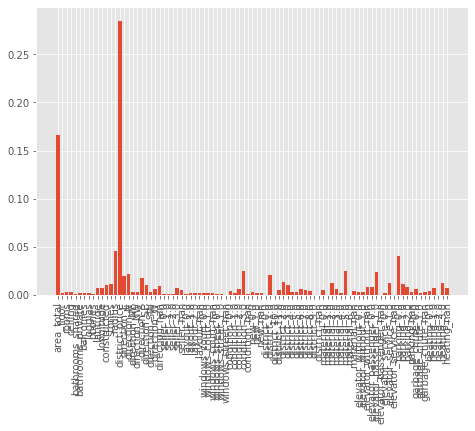

yah


In [29]:


def root_mean_squared_log_error(y_true, y_pred):
    # Alternatively: sklearn.metrics.mean_squared_log_error(y_true, y_pred) ** 0.5
    assert (y_true >= 0).all()
    assert (y_pred >= 0).all()
    log_error = np.log1p(y_pred) - np.log1p(y_true)  # Note: log1p(x) = log(1 + x)
    return np.mean(log_error ** 2) ** 0.5

#data.info()
#print(len(Y))
#print(data.corr())
kaggle = False
if(kaggle):
    XGB_model = xgb.XGBRegressor(n_estimators = 1000)
    Y = np.log(Y)/np.log(15)
    XGB_model.fit(data,Y)
    prediction_kaggle = XGB_model.predict(data_test)
else:
    y_train = np.log(y_train)/np.log(15)
    XGB_model = xgb.XGBRegressor(n_estimators = 1000)
    XGB_model.fit(X_train,y_train)
    prediction = XGB_model.predict(X_test)

    import matplotlib.pyplot as plt

    def plot(model):
        features = model.features_names_in_
        importances = model.features_importances
        fig = plt.figure()
        ax = fig.add_axes([0,0,1,1])
        ax.bar(features, importances)
        plot.show()
    
    fig = plt.figure(figsize=(8, 6), dpi=80)
    ax = fig.add_axes([0,0,1,1])
    ax.bar(XGB_model.get_booster().feature_names, XGB_model.feature_importances_)
    plt.xticks(rotation=90)
    plt.show()
    print("yah")
    


##############



In [30]:



#lgb.plot_importance(lightGBM_model)
#print(data.test)

if(kaggle):
    prediction_kaggle = 15**prediction_kaggle
    submission = pd.DataFrame()
    submission['id'] = test_id
    submission['price_prediction'] = prediction_kaggle
    submission.to_csv('submission_XGB_EDA.csv', index= False)
else:
    prediction = 15**prediction
    rmsle = root_mean_squared_log_error(y_test,prediction)
    print("first run", rmsle)

"""
lightGBM_model = lgb.LGBMRegressor(
    categorical_feature=(0,1,2,8,9,10),
    num_leaves=256,
    max_depth=8,
    random_state=42,
    metric='rmsle',
    num_iterations=2000,
    learning_rate=0.09,
    bagging_freq = 5,
    bagging_fraction = 0.8)
"""

first run 0.13715263327959132


"\nlightGBM_model = lgb.LGBMRegressor(\n    categorical_feature=(0,1,2,8,9,10),\n    num_leaves=256,\n    max_depth=8,\n    random_state=42,\n    metric='rmsle',\n    num_iterations=2000,\n    learning_rate=0.09,\n    bagging_freq = 5,\n    bagging_fraction = 0.8)\n"

Runs
Only numeric, no feature engineered: 0.19744699138034857

Radius added: 0.20967165360778273, Why worse

Distric_mean: 0.19084295853893113

Both Radius and district: 0.196656529295351

One Hot encoding and district: 0.18454859183640202

One HOt, district, loggg: 0.14149042970609157

one_hot, district, log, radius: 0.14492800769942604

one_hot, district, log, radius, long, lat: 0.14029707272730435

one_hot, district, log, radius, long, lat, 10 000 iter:0.1366021699810636

blblbla med cleaning, 1000 iter: 0.14343726755323022

uten clenaing 1000 iter: 0.13981074583345976

blblba med semi- cleaning, 1000 iter: 0.1389066060558281

blbla med semi-cleaning, uten area kitch og den andre, 1000 iter: 0.13715263327959132  gir 0.17 på kaggle